# Using a Custom Multipole Prior with Lenstronomy

This script is based on `starting_guide.py` from the official [Lenstronomy Tutorials](https://github.com/lenstronomy/lenstronomy-tutorials), but includes minimal modifications to enable a custom prior on multipole perturbations of the lens model.<br>

The custom prior (`multipole_logL`) evaluates a joint distribution over lens axis ratio `q` and multipole parameters `(a3_a, delta_phi_m3, a4_a, delta_phi_m4)` using a separately defined non-torch model loaded from a JSON file. The prior encourages realistic galaxy shapes and perturbation amplitudes based on external simulations.<br>

## Key Changes from the Original Tutorial

### 1. Lens Model

The lens model list is updated to:
lens_model_list = ['EPL_MULTIPOLE_M3M4', 'SHEAR']
This enables support for multipole mass perturbations (m=3 and m=4) in addition to external shear.

### 2. Prior Bounds
The parameter bounds for the primary lens (first lens component) are extended to cover the full domain required by the multipole prior:

'e1' and 'e2' ∈ `[-1, +1]`
'delta_phi_m3' ∈ `[-np.pi/6, +np.pi/6]`
'delta_phi_m4' ∈ `[-np.pi/8, +np.pi/8]`

### 3. Custom Log-Likelihood Addition
The multipole prior is incorporated by adding the following line to the kwargs_likelihood dictionary:
`'custom_logL_addition': multipole_logL`
This ensures that Lenstronomy adds the log-probability from the multipole prior to the overall likelihood during inference.


In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from multipole_prior.multipole_prior import multipole_logL  # ### NEW ###
# get_ipython().run_line_magic('matplotlib', 'inline')
try:
    import lenstronomy
except:
    get_ipython().system('pip install lenstronomy')

In [2]:
print("This notebook is running with lenstronomy version", lenstronomy.__version__)

This notebook is running with lenstronomy version 1.12.5


import the LensModel class #

In [3]:
from lenstronomy.LensModel.lens_model import LensModel

specify the choice of lens models #

In [4]:
lens_model_list = ['EPL_MULTIPOLE_M3M4', 'SHEAR']   # ### CHANGED ###

setup lens model class with the list of lens models #

In [5]:
lensModel = LensModel(lens_model_list=lens_model_list)

In [6]:
import lenstronomy.Util.param_util as param_util
e1, e2 = param_util.phi_q2_ellipticity(phi=0.5, q=0.6)
# define parameter values of lens models #
kwargs_epl34 = {'theta_E': 1.1, 'e1': e1, 'e2': e2, 'gamma': 2., 'center_x': 0.0, 'center_y': 0,
                'a3_a': 0.01, 'delta_phi_m3': 0.1, 'a4_a': 0.02, 'delta_phi_m4': 0.2,
                }
kwargs_shear = {'gamma1': -0.01, 'gamma2': .03}
kwargs_lens = [kwargs_epl34, kwargs_shear]

image plane coordinate #

In [7]:
# theta_ra, theta_dec = -0.1, 0.1

source plane coordinate #

In [8]:
beta_ra, beta_dec = 0.1, 0.0 #lensModel.ray_shooting(theta_ra, theta_dec, kwargs_lens)

In [9]:
z_source = 1.5

In [10]:
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

In [11]:
solver = LensEquationSolver(lensModel)

solve for image positions provided a lens model and the source position #

In [12]:
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)

the magnification of the point source images #

In [13]:
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

### illustration of lens models<br>
The lens models can be conveniently illustrated with routines present in the $\texttt{Plot}$ module. As an option, you can plot the critical curves and caustics, which are computationally the most demanding part.

import the LightModel class #

In [14]:
from lenstronomy.LightModel.light_model import LightModel
# set up the list of light models to be used #
source_light_model_list = ['SERSIC']
lightModel_source = LightModel(light_model_list=source_light_model_list)
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list=lens_light_model_list)
# define the parameters #
kwargs_light_source = [{'amp': 100, 'R_sersic': 0.1, 'n_sersic': 1.5, 'center_x': beta_ra, 'center_y': beta_dec}]
kwargs_light_lens = [{'amp': 1000, 'R_sersic': 0.1, 'n_sersic': 2.5, 'e1': e1, 'e2': e2, 'center_x': 0.1, 'center_y': 0}]

evaluate surface brightness at a specific position #

In [15]:
flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

## $\texttt{PointSource}$ module<br>
To accurately predict and model the positon and flux of point sources, one has to apply different numerical procedures than for extended surface brightness features. The $\texttt{PointSource}$ class manages the different options in describing point sources (e.g. in the image plane or source plane, with fixed magnification or allowed with individual variations thereof) and provides a homogeneous interface to access image positions and magnifications.

In[10]:

import the PointSource class #

In [16]:
from lenstronomy.PointSource.point_source import PointSource

unlensed source positon #

In [17]:
point_source_model_list = ['SOURCE_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lens_model=lensModel, fixed_magnification_list=[True])
kwargs_ps = [{'ra_source': beta_ra, 'dec_source': beta_dec, 'source_amp': 100}]
# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

lensed image positions (solution of the lens equation) #

In [18]:
point_source_model_list = ['LENSED_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lens_model=lensModel, fixed_magnification_list=[False])
kwargs_ps = [{'ra_image': theta_ra, 'dec_image': theta_dec, 'point_amp': np.abs(mag)*30}]
# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

## $\texttt{Data}$ module<br>
The $\texttt{PixelGrid}$ class stores and manages the coordinate frame and. the coordinate-to-pixel transformation necessary to simulate images.<br>
The $\texttt{PSF}$ class handles the point spread function convolution. Supported are pixelized convolution kernels as well as some analytic profiles.<br>
<br>
The $\texttt{Data}$ class inherits the $\texttt{PixelGrid}$ and in addition manages data specific quantities (pixel values and noise properties) that are required when fitting models to data to estimate the likelihood of the data given a model. To simulate a mock lens, we only require an instance of the $\texttt{PixelGrid}$ and $\texttt{PSF}$ class.

import the PixelGrid() class #

In [19]:
from lenstronomy.Data.pixel_grid import PixelGrid
deltaPix = 0.05  # size of pixel in angular coordinates #

setup the keyword arguments to create the Data() class #

In [20]:
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 100, 'ny': 100,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

import the PSF() class #

In [21]:
from lenstronomy.Data.psf import PSF
kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.1,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)
# return the pixel kernel corresponding to a point source # 
kernel = psf.kernel_point_source

## $\texttt{ImSim}$ module<br>
The $\texttt{ImSim}$ module simulates images. At its core is the $\texttt{ImageModel}$ class. It is the interface to combine all the different components, $\texttt{LensModel}$, $\texttt{LightModel}$, $\texttt{PointSource}$ and $\texttt{Data}$ to model images. The $\texttt{LightModel}$ can be used to model lens light (unlensed) or source light (lensed). $\texttt{ImSim}$ is fully supporting all functionalities in each component. Additionaly, numerical precision arguments can be set in how to model the image.

### Simulate image<br>
We simulate an image with an instance of $\texttt{ImageModel}$ that got instances of the classes we created above. We can define two different $\texttt{LightModel}$ instances for the lens and source light. Additionally, we can define the sub-pixel ray-tracing resolution and whether the PSF convolution is applied on the higher resolution ray-tracing image or on the degraded pixel image.<br>
<br>
In this example, we do not simulate point source. You can look at the notebooks dedicated to model quads and doubles and also for time-delya cosmography.

In[12]:

import the ImageModel class #

In [22]:
from lenstronomy.ImSim.image_model import ImageModel
# define the numerics #
kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}
# initialize the Image model class by combining the modules we created above #
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=None, # in this example, we do not simulate point source.
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens, kwargs_ps=kwargs_ps)

/Volumes/MavSSD_T5/Dropbox/Google_Drive/code/research_Anna/lenstronomy/lenstronomy/LensModel/Profiles/epl.py:297: RuntimeWarning: invalid value encountered in divide
  R_omega = Z * hyp2f1(1, t / 2, 2 - t / 2, -(1 - q) / (1 + q) * (Z / Z.conj()))


we can also add noise #

In [23]:
import lenstronomy.Util.image_util as image_util
exp_time = 100  # exposure time to quantify the Poisson noise level
background_rms = 0.1  # background rms value
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson

/var/folders/5r/bt9yj5v53wjbj1dp53808kb80000gn/T/ipykernel_19521/872904820.py:3: RuntimeWarning: invalid value encountered in log10
  axes[1].matshow(np.log10(image_noisy), origin='lower')


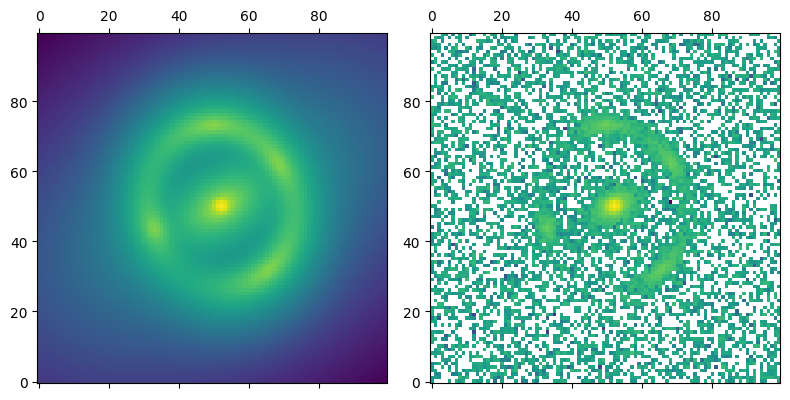

In [24]:
f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=False)
axes[0].matshow(np.log10(image), origin='lower')
axes[1].matshow(np.log10(image_noisy), origin='lower')
f.tight_layout()
plt.show()

### Linear inversion<br>
Parameter corresponding to an an amplitude of a surface brightness distribution have a linear response on the predicted flux values in the data and can be infered by a linear inversion. This can reduce the number of non-linear parameters fastly, depending on the source complexity to be modelled.<br>
<br>
The $\texttt{ImageLinearFit}$ class performs this computation. The class inherits the $\texttt{ImageModel}$ class but instead of the $\texttt{PixelGrid}$ instance, it requires an instance of the full $\texttt{ImageData}$ class including the data (which we use the mock image created above) and the noise properties therof.<br>
<br>
In the example of this notebook, we have 6 linear parameters, the 4 point source amplitudes and the amplitudes of the Sersic profile of the lens and source. *lenstronomy* automatically identifies those parameters and can recover those values (data permitting).<br>


In [25]:
from lenstronomy.Data.imaging_data import ImageData
# update the data with the noisy image and its noise properties #
kwargs_data = {'image_data': image_noisy,
               'background_rms': background_rms,
               'exposure_time': exp_time,
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

In [26]:
data_class = ImageData(**kwargs_data)

In [27]:
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
image_linear_fit = ImageLinearFit(data_class=data_class, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=pointSource, 
                        kwargs_numerics=kwargs_numerics)

we do not require the knowledge of the linear parameters #

In [28]:
del kwargs_light_source[0]['amp']
# apply the linear inversion to fit for the noisy image #
image_reconstructed, _, _, _ = image_linear_fit.image_linear_solve(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source, 
                              kwargs_lens_light=kwargs_light_lens, kwargs_ps=kwargs_ps)

illustrate fit #

In [29]:
from lenstronomy.Plots.model_plot import ModelPlot
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_light_model_list,
               'lens_light_model_list': lens_light_model_list} #, 'point_source_model_list': point_source_model_list}
kwargs_params = {'kwargs_lens': kwargs_lens, 'kwargs_source': kwargs_light_source,
                 'kwargs_lens_light': kwargs_light_lens, 'kwargs_ps': kwargs_ps}
lensPlot = ModelPlot([[kwargs_data, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_params, arrow_size=0.02)

-0.9957454536398451 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9957454536398451


/Volumes/MavSSD_T5/Dropbox/Google_Drive/code/research_Anna/lenstronomy/lenstronomy/Plots/model_band_plot.py:161: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),


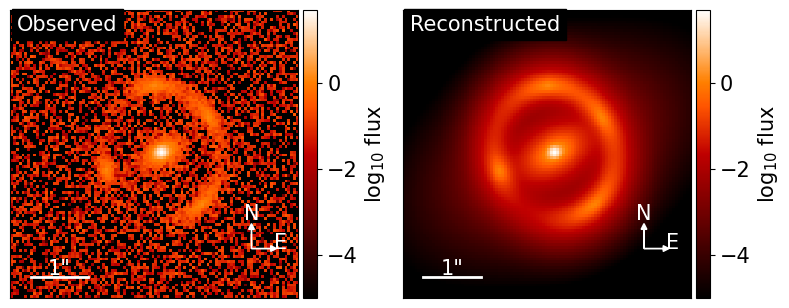

In [30]:
f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=False)
lensPlot.data_plot(ax=axes[0])
lensPlot.model_plot(ax=axes[1])
f.tight_layout()
plt.show()

## $\texttt{Sampling}$ Module<br>
The $\texttt{Sampling}$ Module consists of threee major classes: The $\texttt{Likelihood}$ class manages the specific likelihood function, consisting of the imaging likelihood and potential other data and constraints. The $\texttt{Param}$ class handles all the model choices and the parameters going in it. These classes handle all the model choices of the user and mitigate them to the external modules and from the external modules back to *lenstronomy*.<br>
<br>
The $\texttt{Sampler}$ class gives specific examples how the $\texttt{Likelihood}$ and $\texttt{Param}$ classes can be used to execute specific samplers. This last class can also be replaced by other sampling methods by the user.<br>


### $\texttt{Param}$ class<br>
The $\texttt{Param}$ class is the interface of the *lenstronomy* conventions of parameters (list of keyword arguments) and the fitting conventions of $\texttt{CosmoHammer}$ or $\texttt{emcee}$ (single array consisting all parameters). The $\texttt{Param}$ class enables the user to set further options:<br>
<br>
- keep certain parameters fixed<br>
- handling of the linear parameters<br>
- provide additional constraints on the modelling (e.g. fix source profile to point source position etc)<br>
<br>
With the $\texttt{Param}$ class, lenstronomy can be integrated robustly with other sampling methods.<br>
<br>
<br>
<br>
<br>
<div class="alert alert-warning"><br>
<br>
**ATTENTION:** lenstronomy, by default, solves for the amplitude values of surface brighthness functions (in the lens and source) specified in the model by 'amp' through a linear minimization at each likelihood evaluation step. Solving a linear equation is more efficient than sampling the parameters in the non-linear exploration. Hence, the output of a sampling chain (be it PSO, MCMC or any other sampler used) do not contain the linear amplitudes and are set as =0.<br>
To retriev the linear amplitude parameters, you have to re-do the linear inversion in post processing. This can be done with the $\texttt{LensModelPlot}$ class (see block further down) or with the $\texttt{ImageReconstruction}$ class in the $\texttt{Analysis}$ sub-package.<br>
<br>
</div>

import the parameter handling class #

In [31]:
from lenstronomy.Sampling.parameters import Param
# set options for constraint parameters #
# Here we join the position of the lens light and mass center. 
# There are more options available in the Param() class.
kwargs_constraints = {'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]]}

list fixed parameters #

In [32]:
kwargs_fixed_lens = [{'gamma': 2.}, {'ra_0': 0, 'dec_0': 0}, {}]
kwargs_fixed_source = [{}]
kwargs_fixed_lens_light = [{}]

optional: list lower and upper bounds in parameter space, otherwise it will be using lenstronomy default values! #<br>
list lower bounds in parameter space #

In [33]:
kwargs_lower_lens = [{'theta_E': 0,  'e1': -1., 'e2': -1., 'gamma': 1.5, 'center_x': -10., 'center_y': -10.,
                      'a3_a': -0.1, 'delta_phi_m3': -np.pi/6, 'a4_a': -0.1, 'delta_phi_m4': -np.pi/8},
                     {'gamma1': -0.5, 'gamma2': -0.5}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = None

list upper bounds in parameter space #

In [34]:
kwargs_upper_lens = [{'theta_E': 10, 'e1': 1., 'e2': 1., 'gamma': 2.5, 'center_x': 10., 'center_y': 10.,
                      'a3_a': 0.1,  'delta_phi_m3':  np.pi/6, 'a4_a': 0.1,  'delta_phi_m4':  np.pi/8},
                     {'gamma1': 0.5, 'gamma2': 0.5}]
kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = None

make instance of parameter class with given model options, constraints and fixed parameters #

In [35]:
param = Param(kwargs_model, kwargs_fixed_lens, kwargs_fixed_source,
              kwargs_fixed_lens_light, kwargs_fixed_ps=None, 
              kwargs_lower_lens=kwargs_lower_lens, kwargs_lower_source=kwargs_lower_source,
              kwargs_lower_lens_light=kwargs_lower_lens_light, kwargs_lower_ps=kwargs_lower_ps,
              kwargs_upper_lens=kwargs_upper_lens, kwargs_upper_source=kwargs_upper_source,
              kwargs_upper_lens_light=kwargs_upper_lens_light, kwargs_upper_ps=kwargs_upper_ps,
              kwargs_lens_init=kwargs_lens, **kwargs_constraints)

the number of non-linear parameters and their names #

In [36]:
num_param, param_list = param.num_param()

parameter array for fitting routine #

In [37]:
param_array = param.kwargs2args(kwargs_lens, kwargs_light_source, kwargs_light_lens, kwargs_ps)

recover keyword arguments list for lenstronomy from a parameter array of the fitting routine #

In [38]:
kwargs_out = param.args2kwargs(param_array)

In [39]:
param.print_setting()

The following model options are chosen:
Lens models: ['EPL_MULTIPOLE_M3M4', 'SHEAR']
Source models: ['SERSIC']
Lens light models: ['SERSIC_ELLIPSE']
Point source models: []
The following parameters are being fixed:
Lens: [{'gamma': 2.0, 'center_x': 0, 'center_y': 0}, {'ra_0': 0, 'dec_0': 0}, {}]
Source: [{'amp': 1}]
Lens light: [{'amp': 1}]
Point source: []
Tracer Source: []
Joint parameters for different models
Joint lens with lens: []
Joint lens light with lens light: []
Joint source with source: []
Joint lens with light: [[0, 0, ['center_x', 'center_y']]]
Joint source with point source: []
Joint lens light with point source: []
Joint source light with tracer source: []
Mass scaling: 0 groups
General lens scaling: {}
Number of non-linear parameters being sampled:  19
Parameters being sampled:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'a3_a_lens0', 'delta_phi_m3_lens0', 'a4_a_lens0', 'delta_phi_m4_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_ligh

### $\texttt{Likelihood}$ class<br>
<br>
The $\texttt{Likelihood}$ class performs the likelihood computation. It combines the $\texttt{ImSim}$ module with the $\texttt{Param}$ module. The $\texttt{Likelihood}$ class can evaluate imaging likelihoods, image position and time-delay likelihood with various options. For details we refer to the class documentation.

In[16]:

In [40]:
kwargs_likelihood = {'source_marg': False,
                    'source_position_tolerance': 0.001,
                     'custom_logL_addition': multipole_logL}
single_band = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': single_band, 'multi_band_type': 'multi-linear'}

In [41]:
from lenstronomy.Sampling.likelihood import LikelihoodModule
likelihoodModule = LikelihoodModule(kwargs_data_joint, kwargs_model, param_class=param, **kwargs_likelihood)

/Volumes/MavSSD_T5/Dropbox/Google_Drive/code/research_Anna/lenstronomy/lenstronomy/Sampling/Likelihoods/position_likelihood.py:64: UserWarning: source_position_tolerance has been set but source_position_likelihood is False. 
In order to use the source_position_tolerance, set source_position_likelihood to True
  warnings.warn(


In [42]:
logL = likelihoodModule.logL(args=param_array)

### $\texttt{Sampler}$ class<br>
<br>
The $\texttt{Sampler}$ class performs the sampling of the likelihood. The class requires an instance of the $\texttt{Likelihood}$ class. This class is also meant to showcase the sampling of the *lenstronomy* likelihood. We emphasise that the specific parameter space and complexity may warry significantly and depending on the problem, different approaches can be more efficient.<br>
<br>
<div class="alert alert-warning"><br>
<br>
**Warning:** This particular example was run with a very small and insufficiently long Particle Swarm Optimization. This is for illustrative purpose only. You need to change the 'n_particles' and 'n_iterations' settings and make sure the PSO is sufficiently converged to draw conclusions from the best fit.<br>
<br>
</div>

In[17]:

initial guess of non-linear parameters, we chose different starting parameters than the truth #

In [43]:
kwargs_lens_init = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': 0., 'center_y': 0,
                     'a3_a': 0., 'delta_phi_m3': 0., 'a4_a': 0., 'delta_phi_m4': 0.},
                    {'gamma1': 0, 'gamma2': 0}]
kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 1., 'center_x': 0, 'center_y': 0}]
kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]

initial spread in parameter estimation #

In [44]:
kwargs_lens_sigma = [{'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'gamma': .2, 'center_x': 0.1, 'center_y': 0.1,
                      'a3_a': 0.01,  'delta_phi_m3': 0.5, 'a4_a': 0.01,  'delta_phi_m4': 0.5},
                     {'gamma1': 0.05, 'gamma2': 0.05}]
kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1}]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.2, 'e2': 0.2, 'center_x': .1, 'center_y': 0.1}]

In [45]:
param_init = param.kwargs2args(kwargs_lens_init, kwargs_source_init, kwargs_lens_light_init, kwargs_ps=None)
param_sigma = param.kwargs2args(kwargs_lens_sigma, kwargs_source_sigma, kwargs_lens_light_sigma, kwargs_ps=None)

In [46]:
upper_start = np.array(param_init) + np.array(param_sigma)
lower_start = np.array(param_init) - np.array(param_sigma)

In [47]:
from lenstronomy.Sampling.sampler import Sampler
sampler = Sampler(likelihoodModule=likelihoodModule)

In [48]:
result, chain_properties = sampler.pso(n_particles=200, n_iterations=10, lower_start=lower_start, upper_start=upper_start)

/Volumes/MavSSD_T5/Dropbox/Google_Drive/code/research_Anna/lenstronomy/lenstronomy/LensModel/Profiles/epl.py:297: RuntimeWarning: invalid value encountered in divide
  R_omega = Z * hyp2f1(1, t / 2, 2 - t / 2, -(1 - q) / (1 + q) * (Z / Z.conj()))


Computing the PSO ...


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]

Max iteration reached! Stopping.
-1.6797884904096116 reduced X^2 of best position
-8381.304672898757 log likelihood
9979 effective number of data points
[{'theta_E': 1.033637648605311, 'gamma': 2.0, 'e1': -0.16661071911317937, 'e2': 0.0820263822292136, 'center_x': 0.10359230334750028, 'center_y': 0.0031608302372786315, 'a3_a': -0.0007619972676398265, 'delta_phi_m3': 0.2937590009931316, 'a4_a': 0.006628289015350255, 'delta_phi_m4': -0.17389255794764247}, {'gamma1': 0.00510443284798732, 'gamma2': -0.009361352102492356, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.25967505753093084, 'n_sersic': 1.457489884553072, 'center_x': 0.005358158140842522, 'center_y': -0.05031873683884336}] source result
[{'amp': 1, 'R_sersic': 0.044854492614395725, 'n_sersic': 1.0337570443718498, 'e1': 0.14221539159063737, 'e2': 0.13815677473840088, 'center_x': 0.10359230334750028, 'center_y': 0.0031608302372786315}] lens light result
[] point source result
[] tracer source result
{} special param

In [49]:
kwargs_result = param.args2kwargs(result)

In[18]:

for this part of the code, the emcee MCMC sampler needs to be installed

In [50]:
try:
    import emcee
except:
    get_ipython().system('pip install emcee')

In [51]:
lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_fixed_lens, kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_fixed_source, kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_light_lens, kwargs_lens_light_sigma, kwargs_fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

In [52]:
kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}

In [53]:
band_list = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = []
multi_band_list.append(band_list)

In [54]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=False)

In [55]:
fitting_kwargs_list = [['PSO', {'sigma_scale': 1, 'n_particles': 200, 'n_iterations': 200, 'threadCount': 1}],
                       ['MCMC', {'n_burn': 200, 'n_run': 200, 'n_walkers': 100, 'sigma_scale': .01, 'threadCount': 1}]]

In [56]:
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

/Volumes/MavSSD_T5/Dropbox/Google_Drive/code/research_Anna/lenstronomy/lenstronomy/Sampling/Likelihoods/position_likelihood.py:64: UserWarning: source_position_tolerance has been set but source_position_likelihood is False. 
In order to use the source_position_tolerance, set source_position_likelihood to True
  warnings.warn(


Computing the PSO ...


100%|█████████████████████████████████████████| 200/200 [06:41<00:00,  2.01s/it]


Max iteration reached! Stopping.
-1.0555527246864165 reduced X^2 of best position
-5266.680319822875 log likelihood
9979 effective number of data points
[{'theta_E': 1.1205465430469896, 'gamma': 2.0, 'e1': -0.24996375113466632, 'e2': -0.2843074284157143, 'center_x': 0.10556920982704744, 'center_y': 0.0019428858271440716, 'a3_a': -0.011104437794730375, 'delta_phi_m3': -0.0284466805814164, 'a4_a': -0.06062004574458416, 'delta_phi_m4': 0.05655831771803789}, {'gamma1': -0.12698303548703047, 'gamma2': -0.14585641833365112, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.17440544727169557, 'n_sersic': 4.978119802982272, 'center_x': 0.07769301875497142, 'center_y': 0.016326759827110283}] source result
[{'amp': 1, 'R_sersic': 0.0859053516874352, 'n_sersic': 4.290078612352465, 'e1': 0.1467482365532224, 'e2': 0.21084901833084002, 'center_x': 0.10556920982704744, 'center_y': 0.0019428858271440716}] lens light result
[] point source result
[] tracer source result
{} special param res

100%|█████████████████████████████████████████| 400/400 [07:23<00:00,  1.11s/it]

Computing the MCMC...
Number of walkers =  100
Burn-in iterations:  200
Sampling iterations (in current run): 400
444.7780268192291 time taken for MCMC sampling


<div class="alert alert-warning"><br>
<br>
**Warning:** This particular example was run with a very small and insufficiently long MCMC chain. This is for illustrative purpose only. You need to change the 'n_burn' and 'n_run' settings and make sure the chains are sufficiently converged to draw conclusions from the posteriors.<br>
<br>
</div><br>


### $\texttt{LensModelPlot}$ class<br>
The $\texttt{LensModelPlot}$ facilitates the plotting of models, comparison with the data etc. This class is also meant to illustrate the post-processing.

/Volumes/MavSSD_T5/Dropbox/Google_Drive/code/research_Anna/lenstronomy/lenstronomy/Plots/model_band_plot.py:161: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),


-1.0481185135436124 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0481185135436124


/var/folders/5r/bt9yj5v53wjbj1dp53808kb80000gn/T/ipykernel_19521/991347343.py:10: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


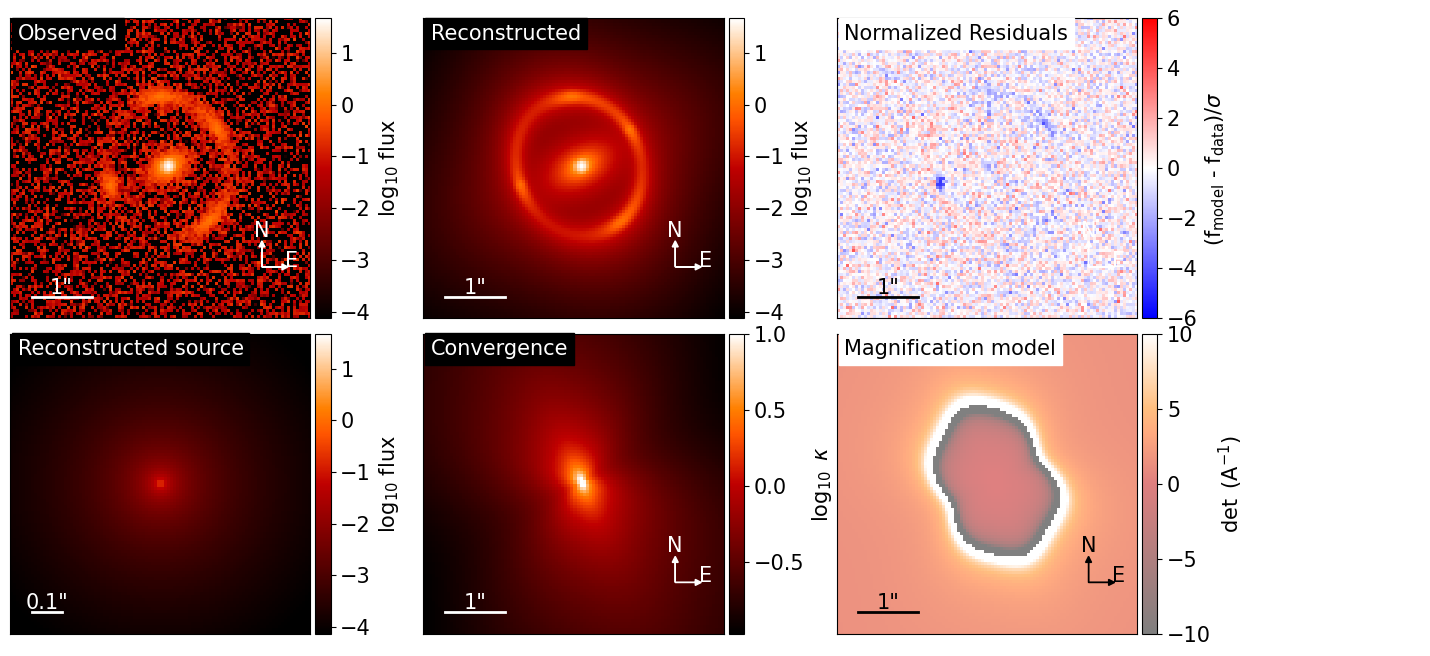

In [57]:
modelPlot = ModelPlot([[kwargs_data, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)
modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

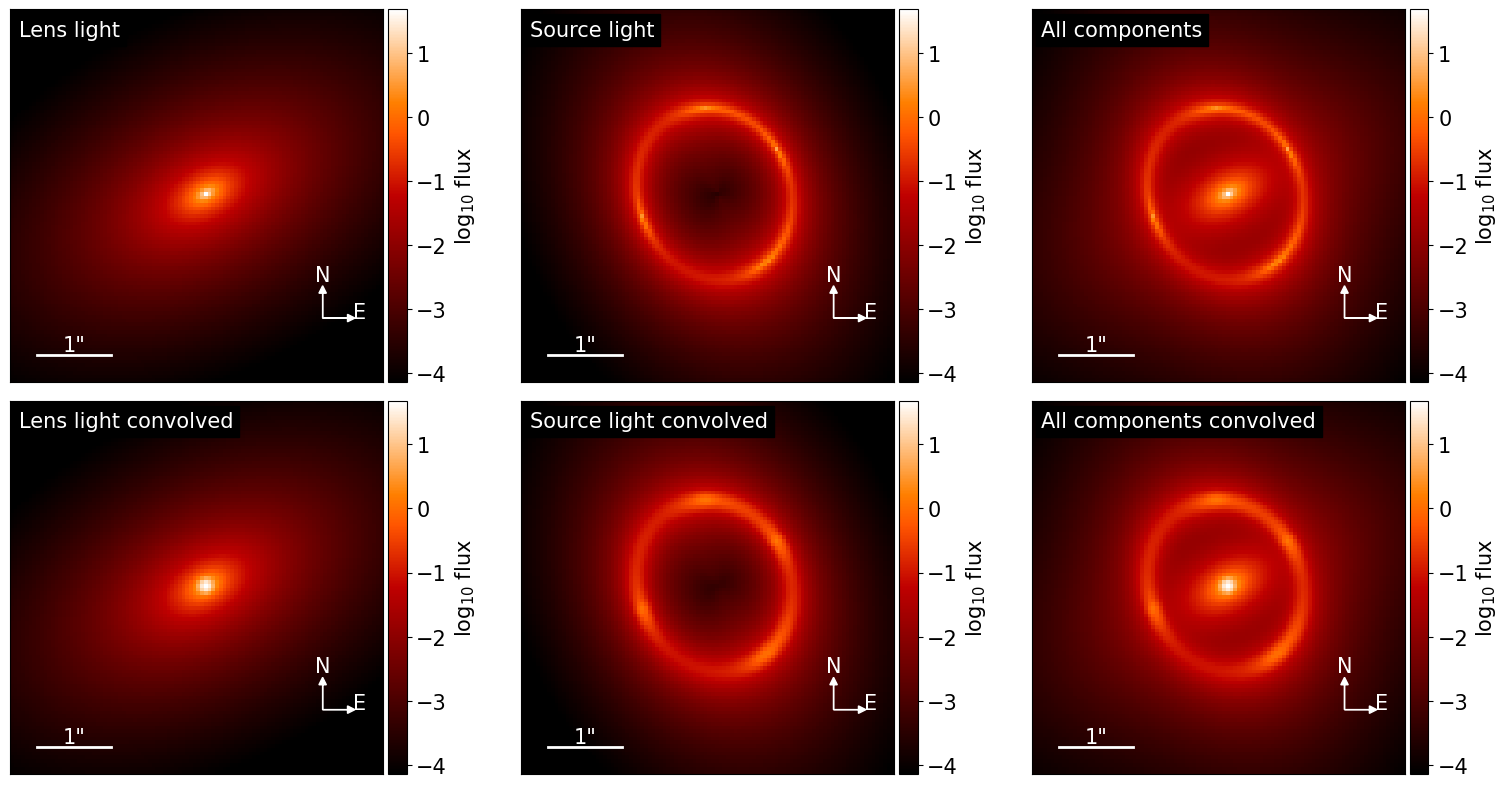

{'kwargs_lens': [{'theta_E': 1.119193351169384, 'gamma': 2.0, 'e1': -0.2583844744993043, 'e2': -0.27331573363066364, 'center_x': 0.1049883275015375, 'center_y': -0.0001797918898078755, 'a3_a': -0.01159865287969468, 'delta_phi_m3': -0.02518926918914337, 'a4_a': -0.05957184746911568, 'delta_phi_m4': 0.06400356382242989}, {'gamma1': -0.13324390006227677, 'gamma2': -0.13873408126759132, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 16.10003323407172, 'R_sersic': 0.1595106201086656, 'n_sersic': 4.977855642332392, 'center_x': 0.07801916008961156, 'center_y': 0.01330934633708196}], 'kwargs_lens_light': [{'amp': 1294.070930378998, 'R_sersic': 0.0874796292766185, 'n_sersic': 4.2889124586693805, 'e1': 0.14423695905394113, 'e2': 0.2074840326575836, 'center_x': 0.1049883275015375, 'center_y': -0.0001797918898078755}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tracer_source': []}


In [58]:
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)
modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

In [59]:
from lenstronomy.Plots import chain_plot

here we get the truths of the input that we aim to recover in the MCMC chain with the help of the Param() class.<br>
we can also get the Param() class instance from the FittingSequence() instancd

In [60]:
param = fitting_seq.param_class
param_array_truths = param.kwargs2args(kwargs_lens, kwargs_light_source, kwargs_light_lens, kwargs_ps)

number of non-linear parameters in the MCMC process:  19
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'a3_a_lens0', 'delta_phi_m3_lens0', 'a4_a_lens0', 'delta_phi_m4_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  20000


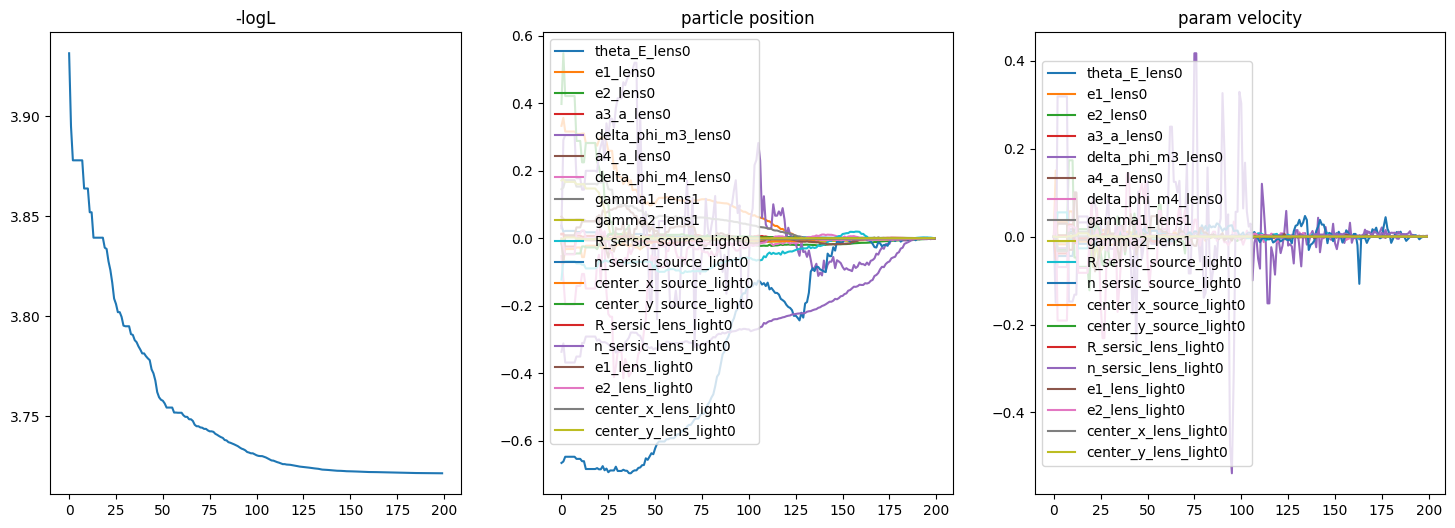

<Figure size 640x480 with 0 Axes>

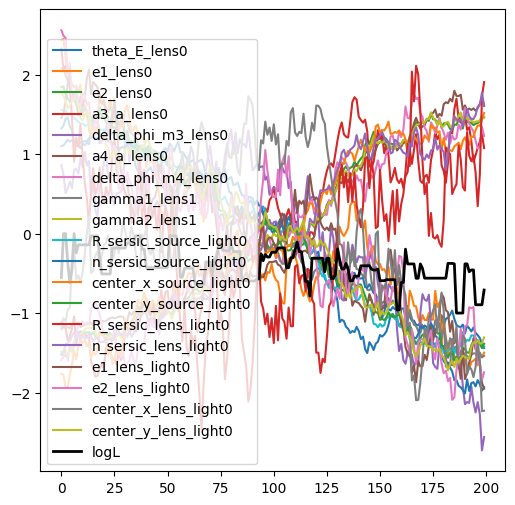

In [61]:
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

In [62]:
import corner  # pip install corner  (if you have not installed it)

/var/folders/5r/bt9yj5v53wjbj1dp53808kb80000gn/T/ipykernel_19521/3277635430.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()
/var/folders/5r/bt9yj5v53wjbj1dp53808kb80000gn/T/ipykernel_19521/3277635430.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


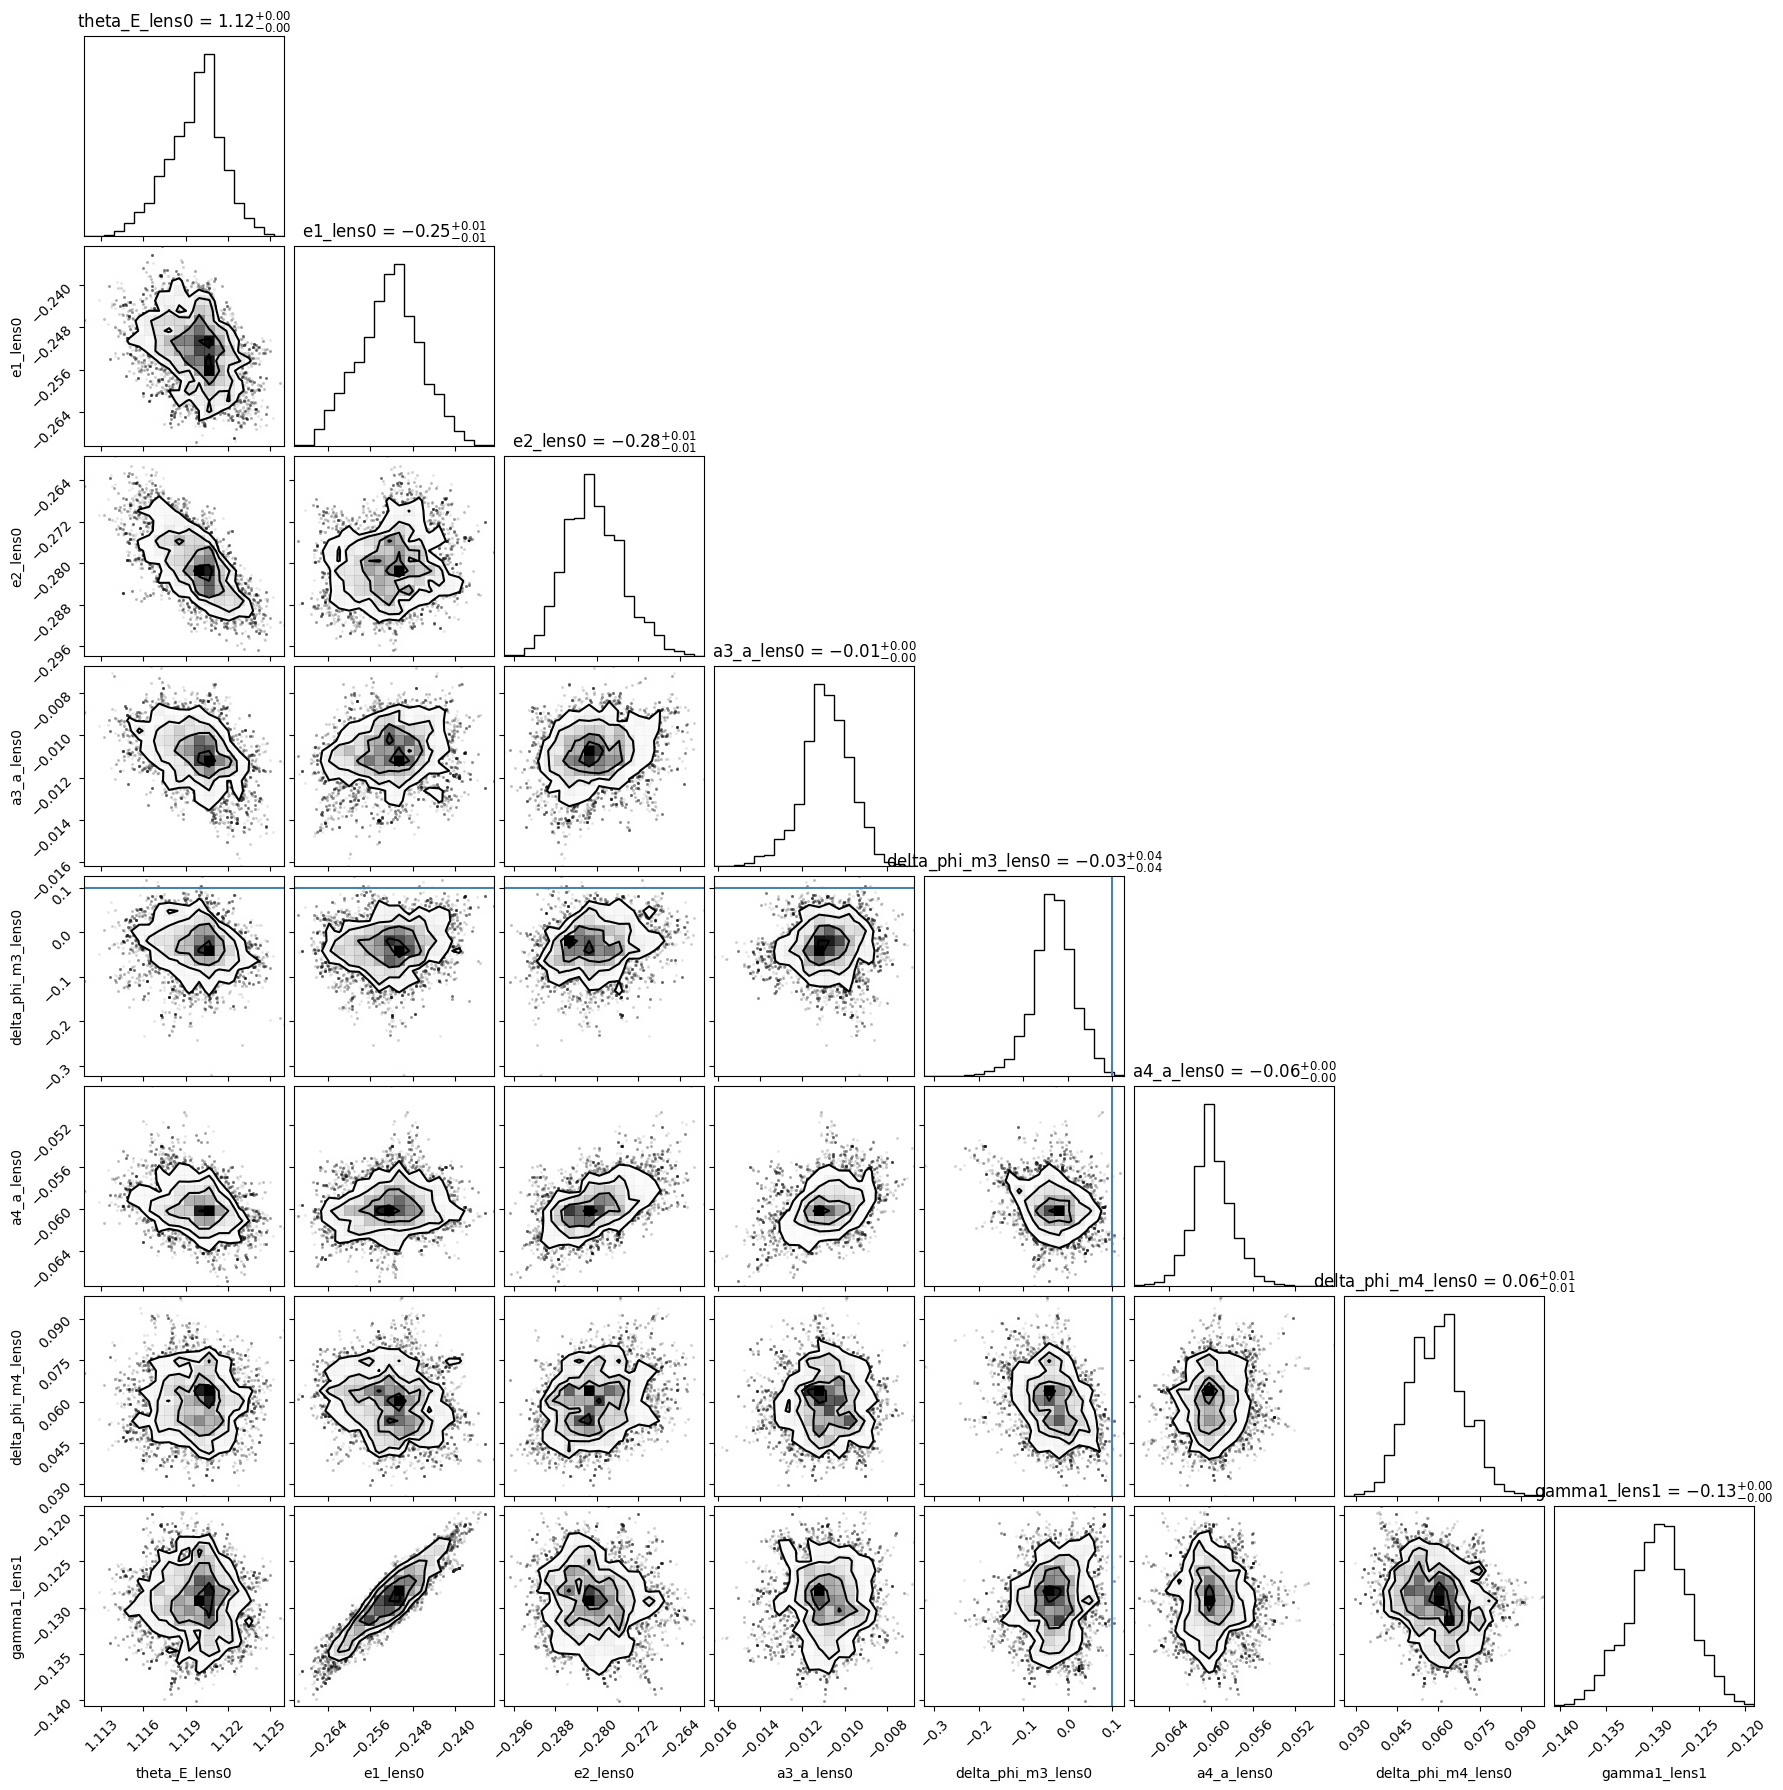

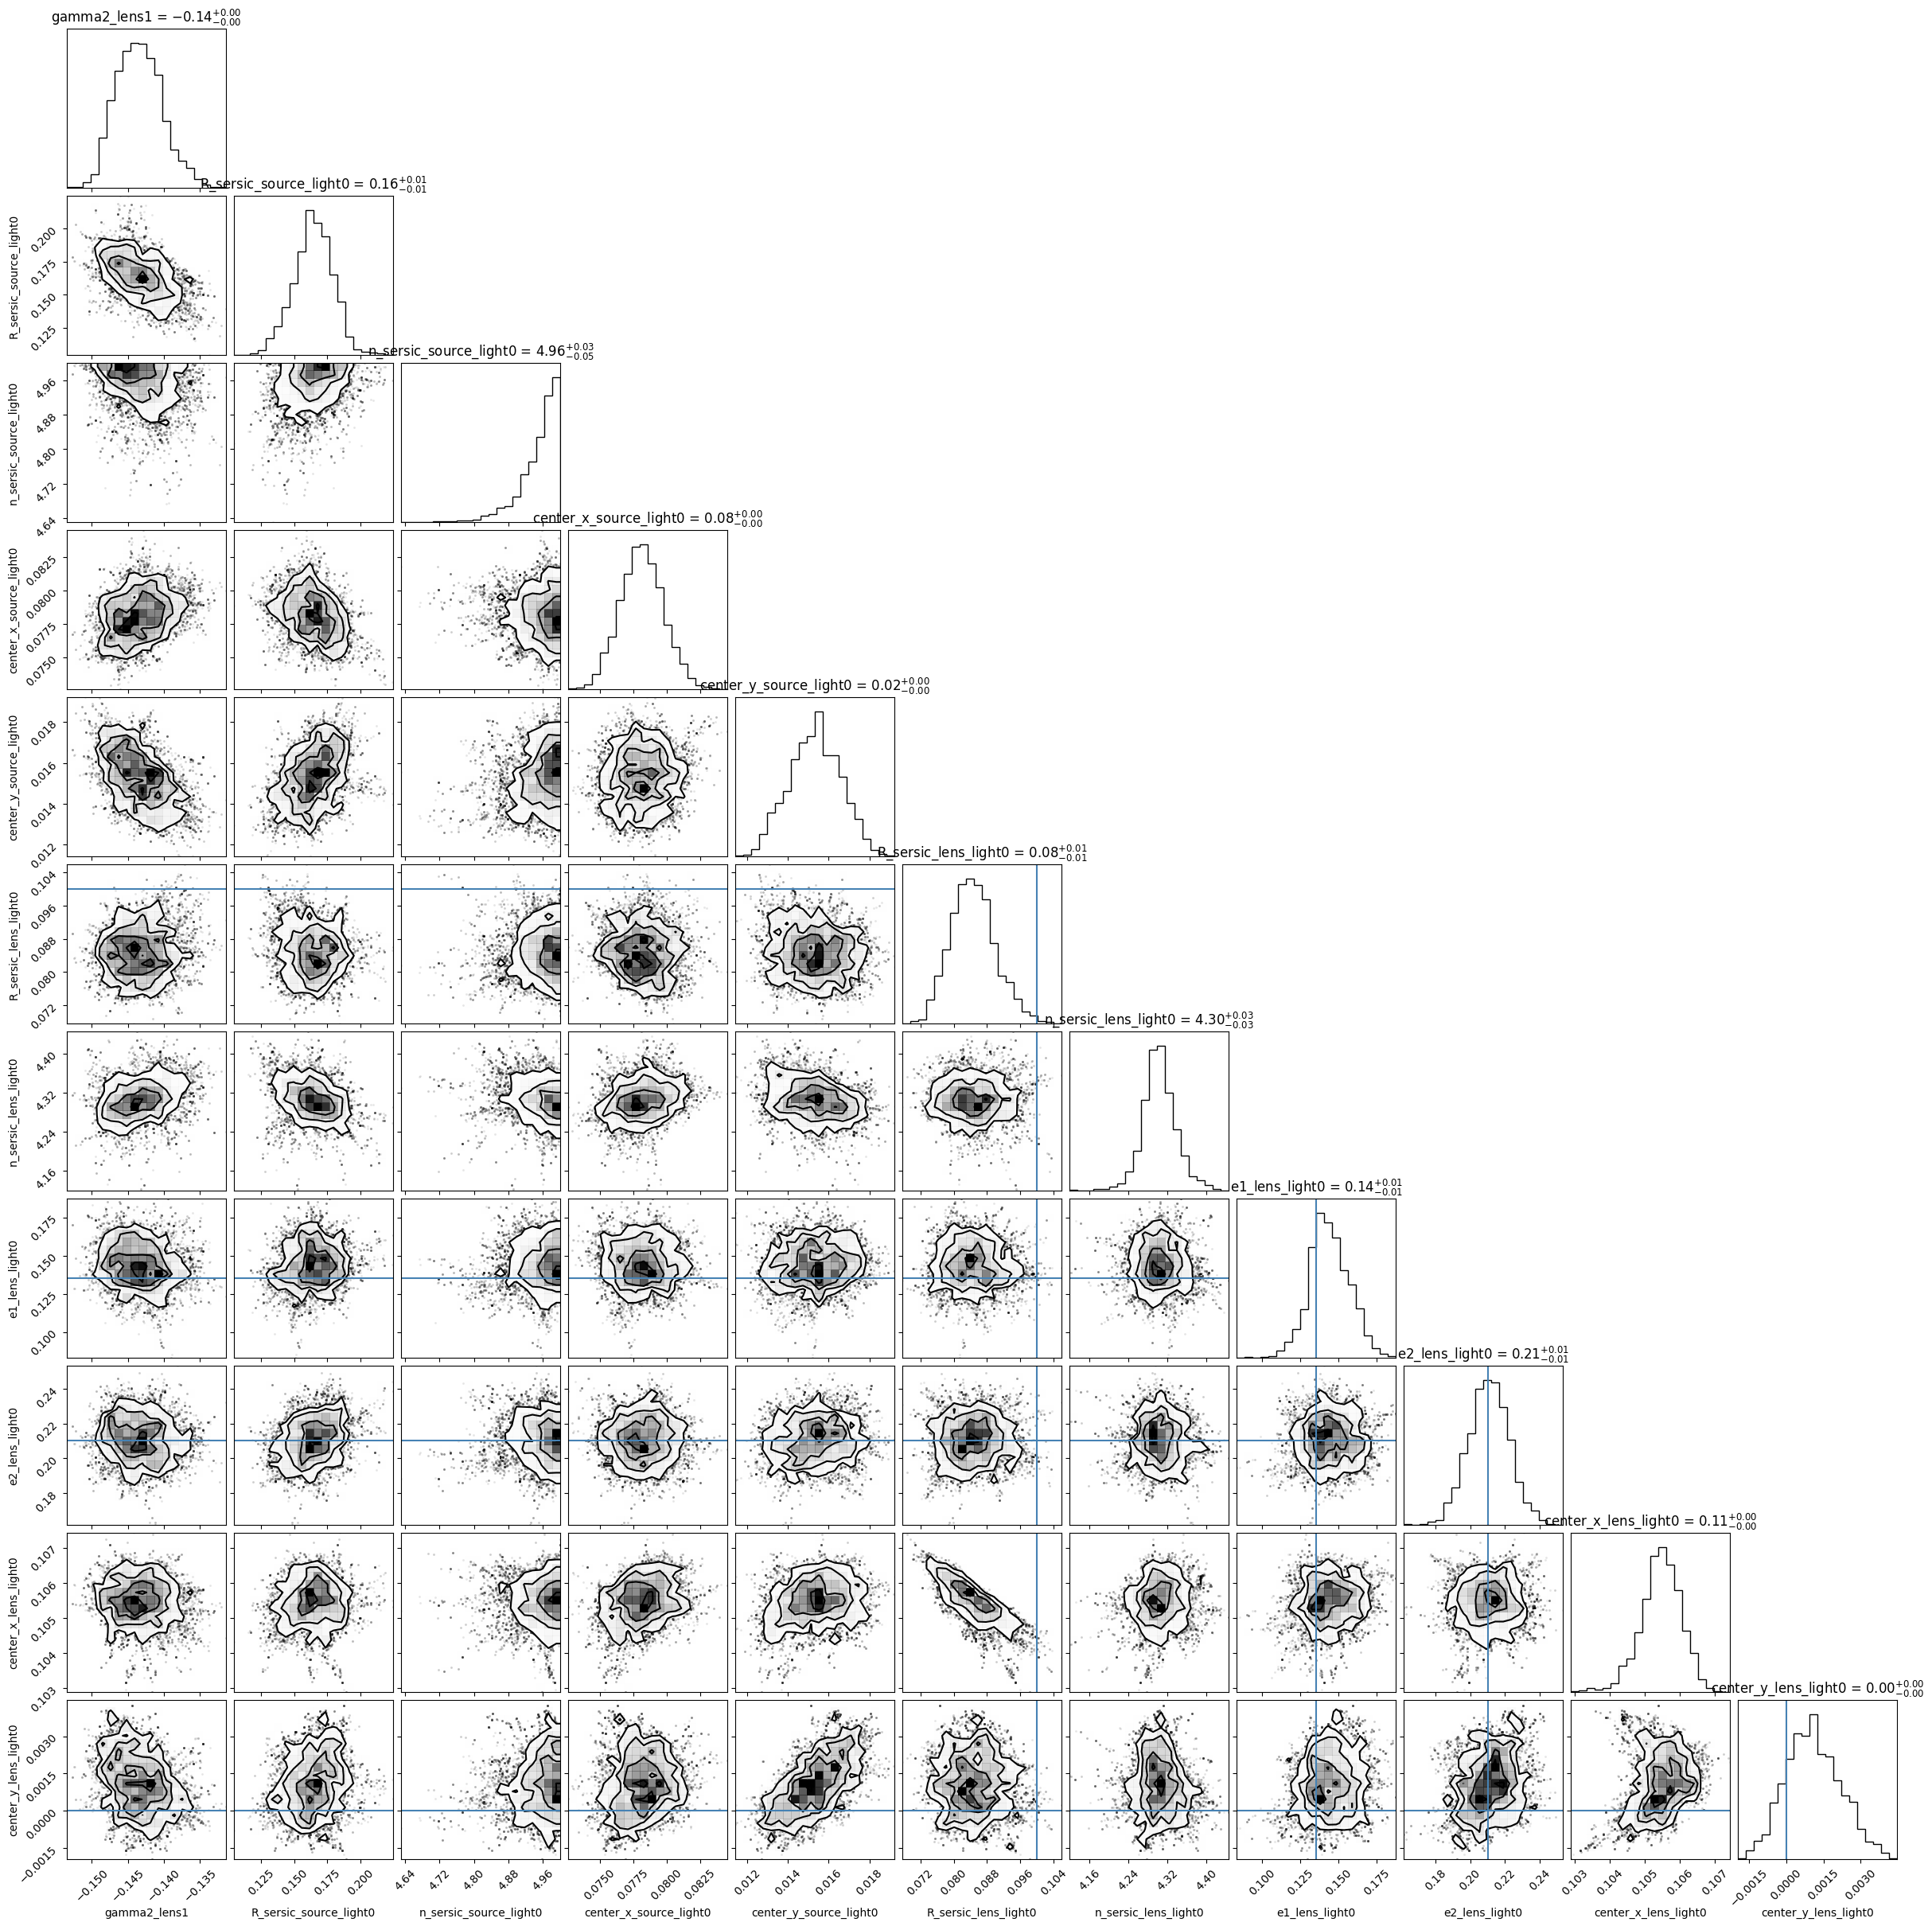

In [63]:
n, num_param = np.shape(samples_mcmc)
plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True, truths=param_array_truths[:8])
plot.show()
plot = corner.corner(samples_mcmc[:,8:], labels=param_mcmc[8:], show_titles=True, truths=param_array_truths[8:])
plot.show()
        